In [1]:
from sklearn.metrics import confusion_matrix, classification_report      
from sklearn.metrics import roc_auc_score

import torch
from torch import nn

from torchvision import transforms, models
from XrayDataset import XrayDataset
from torch.utils.data import DataLoader
import itertools
from utils import plot_confusion_matrix



Bad key "text.kerning_factor" on line 4 in
/home/ramkik/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
checkpoint_path = 'ckpt-900.pth.tar'

In [3]:
model = models.resnet50(pretrained=True)


In [4]:
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 3))

In [5]:
checkpoint  = torch.load(checkpoint_path)

In [6]:
distributed_state_dict = checkpoint['state_dict']

In [7]:
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in distributed_state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v

In [8]:
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [9]:
model = model.cuda()

In [10]:
criterion = nn.CrossEntropyLoss()


In [11]:
batch_size = 128

In [12]:
test_transforms = transforms.Compose([
                                      transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.5], std=[0.5])
                                      ])

In [13]:
train_dataset = XrayDataset( 'data', 'train', 'train.csv', test_transforms )

dataloader = DataLoader(train_dataset, batch_size=batch_size,  shuffle=True, num_workers=4)
test_dataset = XrayDataset('data', 'test', 'test.csv', test_transforms )
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False, num_workers=4)

In [14]:
model.eval()


correct = 0
total = 0
running_loss = 0.0
predicted_labels = []
true_labels = []
y_score = []

with torch.no_grad():
    for i, (input, target) in enumerate(dataloader):
        target = target.cuda()

        # compute output
        output = model(input.cuda())
        loss = criterion(output, target)
        _, predicted = torch.max(output.data, 1)
        predicted_labels.append(predicted.tolist())
        y_score.append(output.cpu())
        true_labels.append(target.tolist())
        #print(y_score)
        #print(torch.squeeze(predicted), "--->", target )
        total += target.size(0)
        correct += (predicted == target).sum().item()

        running_loss += loss.item()

predicted_labels = list(itertools.chain(*predicted_labels))
true_labels = list(itertools.chain(*true_labels))

accurecy = 100 * correct / total


In [15]:
classes = ['normal', 'COVID-19', 'other_pneumonia']

In [16]:
class_dict ={classes[i]: i for i in range(3)}

In [17]:
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion matrix")
print(cm)

Confusion matrix
[[408   0   0]
 [  0 114   0]
 [  0   0 423]]


In [18]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       408
           1       1.00      1.00      1.00       114
           2       1.00      1.00      1.00       423

    accuracy                           1.00       945
   macro avg       1.00      1.00      1.00       945
weighted avg       1.00      1.00      1.00       945



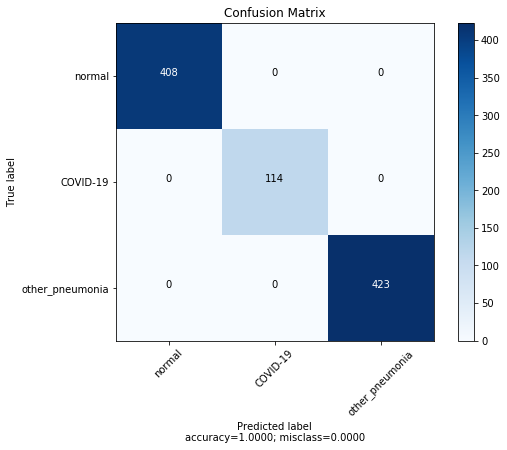

In [19]:
plot_confusion_matrix(cm, normalize    = False,
                      target_names = classes,
                      title        = "Confusion Matrix")

In [20]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from  sklearn.metrics import precision_recall_fscore_support

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
def test_class_probabilities(model, test_loader, which_class):
    model.eval()
    actuals = []
    probabilities = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction) == which_class)
            output = output.cpu()
            probabilities.extend(np.exp(output[:, which_class]))
    return [i.item() for i in actuals], [i.item() for i in probabilities]

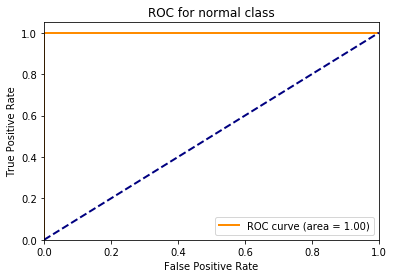

In [22]:
which_class = 0
actuals, class_probabilities = test_class_probabilities(model, dataloader, which_class)

fpr, tpr, _ = roc_curve(actuals, class_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for normal class')
plt.legend(loc="lower right")
plt.show()

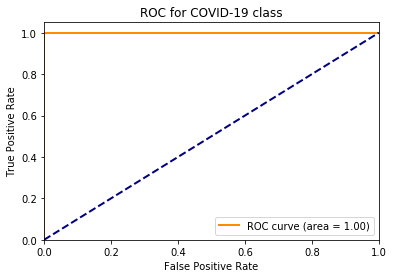

In [23]:
which_class = 1
actuals, class_probabilities = test_class_probabilities(model, dataloader, which_class)

fpr, tpr, _ = roc_curve(actuals, class_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for COVID-19 class')
plt.legend(loc="lower right")
plt.show()

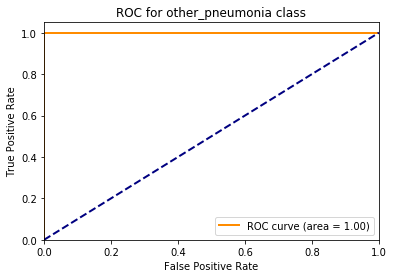

In [24]:
which_class = 2
actuals, class_probabilities = test_class_probabilities(model, dataloader, which_class)

fpr, tpr, _ = roc_curve(actuals, class_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for other_pneumonia class')
plt.legend(loc="lower right")
plt.show()

In [25]:
model.eval()


correct = 0
total = 0
running_loss = 0.0
predicted_labels = []
true_labels = []
y_score = []

with torch.no_grad():
    for i, (input, target) in enumerate(test_dataloader):
        target = target.cuda()

        # compute output
        output = model(input.cuda())
        loss = criterion(output, target)
        _, predicted = torch.max(output.data, 1)
        predicted_labels.append(predicted.tolist())
        y_score.append(output.cpu())
        true_labels.append(target.tolist())
        #print(y_score)
        #print(torch.squeeze(predicted), "--->", target )
        total += target.size(0)
        correct += (predicted == target).sum().item()

        running_loss += loss.item()

predicted_labels = list(itertools.chain(*predicted_labels))
true_labels = list(itertools.chain(*true_labels))

accurecy = 100 * correct / total


In [26]:
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion matrix")
print(cm)

Confusion matrix
[[39  0  6]
 [ 0 11  2]
 [10  0 37]]


In [27]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83        45
           1       1.00      0.85      0.92        13
           2       0.82      0.79      0.80        47

    accuracy                           0.83       105
   macro avg       0.87      0.83      0.85       105
weighted avg       0.83      0.83      0.83       105



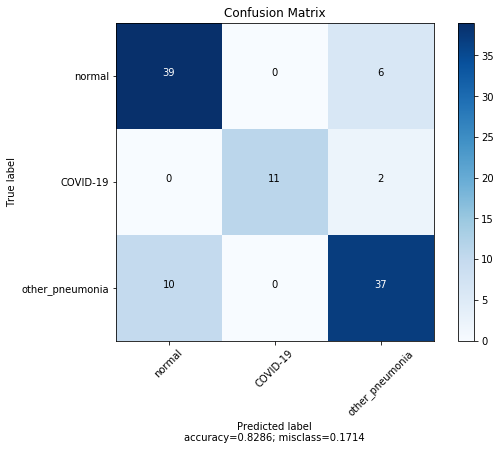

In [28]:
plot_confusion_matrix(cm, normalize    = False,
                      target_names = classes,
                      title        = "Confusion Matrix")

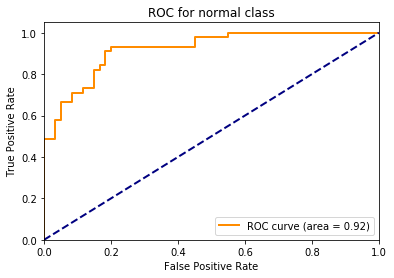

In [29]:
which_class = 0
actuals, class_probabilities = test_class_probabilities(model, test_dataloader, which_class)

fpr, tpr, _ = roc_curve(actuals, class_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for normal class')
plt.legend(loc="lower right")
plt.show()

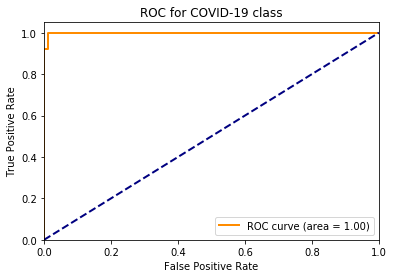

In [30]:
which_class = 1
actuals, class_probabilities = test_class_probabilities(model, test_dataloader, which_class)

fpr, tpr, _ = roc_curve(actuals, class_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for COVID-19 class')
plt.legend(loc="lower right")
plt.show()

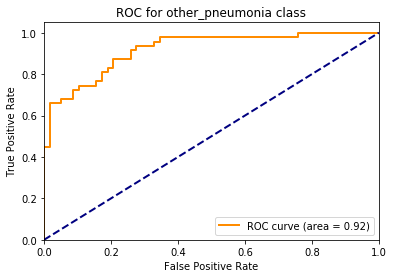

In [31]:
which_class = 2
actuals, class_probabilities = test_class_probabilities(model, test_dataloader, which_class)

fpr, tpr, _ = roc_curve(actuals, class_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for other_pneumonia class')
plt.legend(loc="lower right")
plt.show()